In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.fftpack import fft, fft2, ifft2
from scipy.integrate import solve_ivp
from scipy.linalg import solve, solve_triangular, lu
from scipy.sparse import spdiags

In [2]:
t_span = np.arange(0, 4.5, 0.5)
nu = 0.001
Lx, Ly = 20, 20
nx, ny = 64, 64
N = nx * ny

x2 = np.linspace(-Lx/2, Lx/2, nx + 1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny + 1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)

omega = (np.exp((-X**2 - (Y**2) / 20))).flatten()

kx = (2 * np.pi / Lx) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
kx[0] = 1e-6
ky = (2 * np.pi / Ly) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2

In [3]:
# HW4 i.c.
m = 64
L = 20
dx = L / m
n = m * m

e0 = np.zeros(n)
e1 = np.ones(n)
e2 = np.copy(e1)
e4 = np.copy(e0)

for j in range(1, m+1):
    e2[m*j - 1] = 0 
    e4[m*j - 1] = 1

# Adjusted vectors for diagonals
e3 = np.zeros_like(e2)
e3[1:n] = e2[0:n-1]
e3[0] = e2[n-1]

e5 = np.zeros_like(e4)
e5[1:n] = e4[0:n-1]
e5[0] = e4[n-1]

# Construct Matrix a (Laplacian)
diagonals_A = [e1, e1, e5, e2, -4 * e1, e3, e4, e1, e1]
offsets_A = [-(n - m), -m, -m + 1, -1, 0, 1, m - 1, m, (n - m)]
A = (spdiags(diagonals_A, offsets_A, n, n) / (dx**2)).toarray()

# Construct Matrix C (Partial derivative with respect to y)
diagonals_B = [e1, -e1, e1, -e1]
offsets_B = [-(n - m),-m, m, (n - m)]
B = (spdiags(diagonals_B, offsets_B, n, n) / (2 * dx)).toarray()

# Construct Matrix b (Partial derivative with respect to x)
diagonals_C = [e5, -e2, e3, -e4]
offsets_C = [-m + 1, -1, 1, m - 1]
C = (spdiags(diagonals_C, offsets_C, n, n) / (2 * dx)).toarray()

A[0, 0] = 2

In [4]:
def spc_rhs(t, omega, nx, ny, K, nu):
    wt = fft2(omega.reshape((nx, ny)))
    psit = -wt / K
    psi = (np.real(ifft2(psit))).flatten()
    rhs = nu * np.dot(A, omega) - np.dot(B, psi) * np.dot(C, omega) + np.dot(C, psi) * np.dot(B, omega)
    return rhs

start_time = time.time()
wtsol = solve_ivp(spc_rhs, (0, 4), omega, t_eval=t_span, method = 'RK45', args = (nx, ny, K, nu))
A1 = wtsol.y
end_time = time.time()

time_fft = end_time-start_time

print(A1)
print("Time to run fft : ", time_fft)

[[2.50656748e-46 3.58115533e-45 1.88145182e-44 ... 1.89153384e-42
  4.77683710e-42 1.13610124e-41]
 [1.17762859e-43 6.52986836e-43 2.62268427e-42 ... 1.58830666e-40
  3.56101180e-40 7.46707047e-40]
 [4.55107657e-41 1.92940598e-40 6.43573188e-40 ... 2.49204295e-38
  5.07937229e-38 9.69486996e-38]
 ...
 [1.96785570e-38 1.23404992e-37 5.47731448e-37 ... 4.35470613e-35
  1.02316938e-34 2.22850208e-34]
 [6.19028421e-41 5.33954726e-40 2.94129649e-39 ... 3.68077606e-37
  9.45511339e-37 2.23647594e-36]
 [1.60178709e-43 1.99512062e-42 1.41619269e-41 ... 2.80039439e-39
  7.95688616e-39 2.07564327e-38]]
Time to run fft :  1.1374390125274658


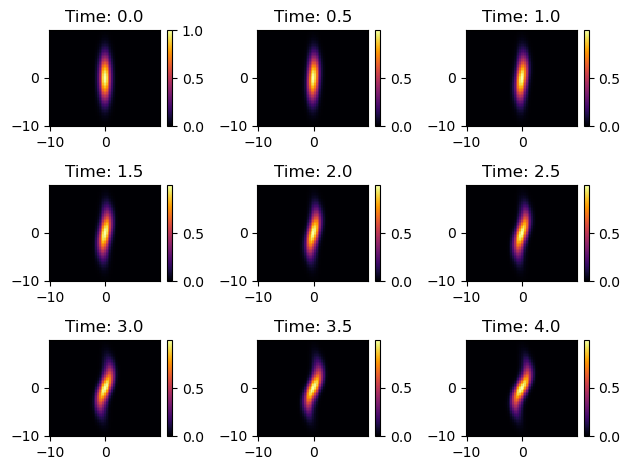

In [5]:
for j, t in enumerate(t_span):
    omega_t = A1[:, j].reshape((ny, nx)) 
    plt.subplot(3, 3, j + 1)
    plt.pcolor(x, y, omega_t, shading='auto', cmap='inferno')
    plt.title(f'Time: {t}')
    plt.colorbar()

plt.tight_layout()
plt.show()

In [6]:
# A\b
w_ds = (np.exp(-X**2 - (Y**2)/20)).flatten()

def spc_rhs_gaussian(t, w_ds, nu, A, B, C):
    psi = solve(A, w_ds)
    return nu * np.dot(A, w_ds) - np.dot(B, psi) * np.dot(C, w_ds) + np.dot(C, psi) * np.dot(B, w_ds)

start_time = time.time()
wtsol_ds = solve_ivp(spc_rhs_gaussian, (0, 4), w_ds, t_eval=t_span, method = 'RK45', args = (nu, A, B, C))
A2 = wtsol_ds.y
end_time = time.time()

a_b_time = end_time - start_time

print(A2)
print("Time to run  A@b : ", a_b_time)

[[ 2.50656748e-46 -1.78784704e-36  1.02706391e-36 ... -5.76806489e-26
  -6.68287054e-25  3.02050167e-24]
 [ 1.17762859e-43 -2.26093387e-29  1.85614646e-29 ... -1.48306461e-19
  -7.82424220e-19  1.67449651e-18]
 [ 4.55107657e-41 -4.24661881e-29  3.48720993e-29 ... -2.20165937e-20
  -2.91637720e-19  1.23961335e-18]
 ...
 [ 1.96785570e-38  7.20814729e-28 -6.58759786e-28 ...  4.01674620e-20
   1.34371413e-19 -8.94163775e-19]
 [ 6.19028421e-41  1.69117621e-28 -1.49205998e-28 ...  3.00460834e-20
   1.76009486e-19 -9.80736832e-19]
 [ 1.60178709e-43  5.05834665e-29 -4.38046443e-29 ...  2.47633369e-20
   1.15181522e-20  3.12761254e-20]]
Time to run  A@b :  61.87671399116516


In [7]:
# LU
w_lu = (np.exp(-X**2 - (Y**2)/20)).flatten()

P, L, U = lu(A)

def spc_rhs_lu(t, w_lu, nu, A, B, C, P, L):
    Pw = np.dot(P, w_lu)
    foo = solve_triangular(L, Pw, lower=True)
    psi = solve_triangular(U, foo)
    return nu * np.dot(A, w_lu) - np.dot(B, psi) * np.dot(C, w_lu) + np.dot(C, psi) * np.dot(B, w_lu)


start_time = time.time()
wtsol_lu = solve_ivp(spc_rhs_lu, (0, 4), w_lu, t_eval=t_span, method = 'RK45', args = (nu, A, B, C, P, L))
A3 = wtsol_lu.y
end_time = time.time()

lu_time = end_time - start_time

print(A3)
print("Time to run lu : ", lu_time)

[[ 2.50656748e-46 -1.78784704e-36  1.02706391e-36 ... -5.76806489e-26
  -6.68287054e-25  3.02050167e-24]
 [ 1.17762859e-43 -2.26093387e-29  1.85614646e-29 ... -1.48306461e-19
  -7.82424220e-19  1.67449651e-18]
 [ 4.55107657e-41 -4.24661881e-29  3.48720993e-29 ... -2.20165937e-20
  -2.91637720e-19  1.23961335e-18]
 ...
 [ 1.96785570e-38  7.20814729e-28 -6.58759786e-28 ...  4.01674620e-20
   1.34371413e-19 -8.94163775e-19]
 [ 6.19028421e-41  1.69117621e-28 -1.49205998e-28 ...  3.00460834e-20
   1.76009486e-19 -9.80736832e-19]
 [ 1.60178709e-43  5.05834665e-29 -4.38046443e-29 ...  2.47633369e-20
   1.15181522e-20  3.12761254e-20]]
Time to run lu :  2.49271297454834


In [8]:
from scipy.sparse.linalg import bicgstab, gmres

# BiCGSTAB Solver
w_bicgstab = (np.exp(-X**2 - (Y**2)/20)).flatten()

def spc_rhs_bicgstab(t, w_bicgstab, nu, A, B, C):
    psi, e = bicgstab(A, w_bicgstab, rtol=1e-4)
    # if e !=0 :
    #     raise ValueError("bicgstab did not converge, reason : ", e)
    return nu * np.dot(A, w_bicgstab) - np.dot(B, psi) * np.dot(C, w_bicgstab) + np.dot(C, psi) * np.dot(B, w_bicgstab)

start_time = time.time()
wtsol_bicgstab = solve_ivp(spc_rhs_bicgstab, (0, 4), w_bicgstab, t_eval=t_span, method='RK45', args=(nu, A, B, C))
A4 = wtsol_bicgstab.y
end_time = time.time()

bicgstab_t = end_time - start_time

print(A4)
print("Time to run BiCGSTAB : ", bicgstab_t)

[[ 2.50656748e-46 -2.85965565e-38  2.99694786e-32 ... -1.27365180e-25
   5.35145820e-26  3.21134432e-27]
 [ 1.17762859e-43 -1.90665847e-31  6.07180504e-25 ... -4.57333037e-19
   6.50423034e-19 -2.29542350e-19]
 [ 4.55107657e-41 -3.55632992e-31  4.97664618e-25 ... -4.59132099e-20
   4.09189632e-21  2.34121156e-19]
 ...
 [ 1.96785570e-38  4.03393898e-30  1.45870289e-24 ...  1.08395858e-19
  -1.72005615e-19 -4.50303236e-20]
 [ 6.19028421e-41  1.10609496e-30  1.64890745e-25 ...  7.43891637e-20
  -9.53272098e-20 -1.14864987e-19]
 [ 1.60178709e-43  3.56399071e-31 -1.95665038e-25 ...  7.90988980e-20
  -1.51127150e-19 -2.63243703e-19]]
Time to run BiCGSTAB :  200.3842968940735


In [9]:
# GMRES Solver
w_gmres = (np.exp(-X**2 - (Y**2)/20)).flatten()

def spc_rhs_gmres(t, w_gmres, nu, A, B, C):
    psi, e = gmres(A, w_gmres, rtol=1e-4, maxiter=20)
    # if e != 0:
    #     raise ValueError("gmres did not converge, reason : ", e)
    return nu * np.dot(A, w_gmres) - np.dot(B, psi) * np.dot(C, w_gmres) + np.dot(C, psi) * np.dot(B, w_gmres)

start_time = time.time()
wtsol_gmres = solve_ivp(spc_rhs_gmres, (0, 4), w_gmres, t_eval=t_span, method='RK45', args=(nu, A, B, C))
A5 = wtsol_gmres.y
end_time = time.time()

gmres_t = end_time - start_time

print(A5)
print("Time to run GMRES : ", gmres_t)


[[ 2.50656748e-46  1.64750463e-42  5.55054526e-35 ... -1.98183853e-31
   1.20322521e-30 -1.58735668e-29]
 [ 1.17762859e-43  3.58288579e-35  2.38735282e-29 ... -7.62581388e-25
   1.89483061e-24 -2.06866153e-24]
 [ 4.55107657e-41  1.39944715e-34  3.39126723e-29 ... -8.26940727e-25
   2.21179262e-24 -2.37554160e-24]
 ...
 [ 1.96785570e-38 -7.85282057e-33 -6.85233763e-28 ...  7.20559164e-25
  -5.49245493e-24  2.47185324e-23]
 [ 6.19028421e-41 -1.00644554e-33 -2.39563577e-28 ...  9.60932132e-25
  -3.76453499e-24  1.13832606e-23]
 [ 1.60178709e-43 -1.78136541e-34 -9.54261702e-29 ...  8.51968136e-25
  -2.53457552e-24  5.28852980e-24]]
Time to run GMRES :  117.44009113311768


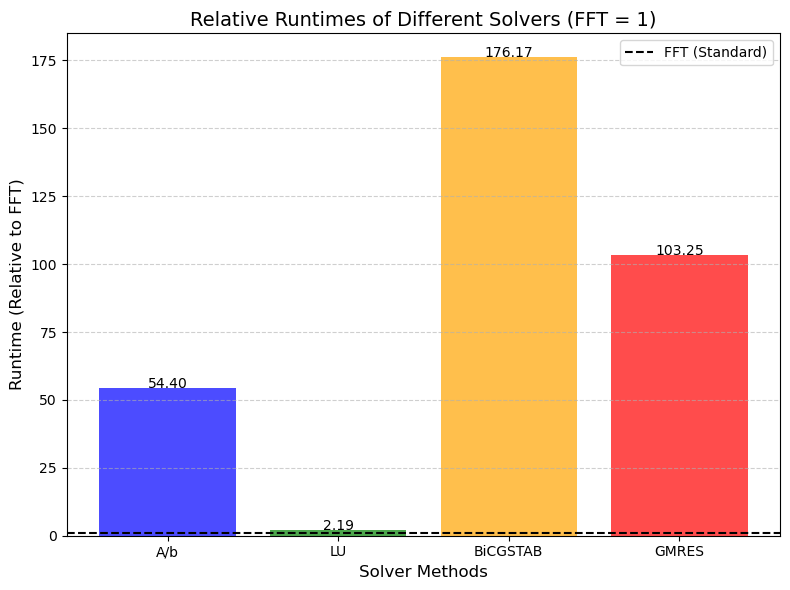

In [10]:
import matplotlib.pyplot as plt

# Normalize runtimes to FFT
times = [a_b_time / time_fft, lu_time / time_fft, bicgstab_t / time_fft, gmres_t / time_fft]
methods = ['A/b', 'LU', 'BiCGSTAB', 'GMRES']

# Visualization
plt.figure(figsize=(8, 6))
plt.bar(methods, times, color=['blue', 'green', 'orange', 'red'], alpha=0.7)
plt.axhline(y=1, color='black', linestyle='--', label='FFT (Standard)')

# Annotating each bar with its value
for i, val in enumerate(times):
    plt.text(i, val + 0.05, f'{val:.2f}', ha='center', fontsize=10)

# Chart formatting
plt.title('Relative Runtimes of Different Solvers (FFT = 1)', fontsize=14)
plt.ylabel('Runtime (Relative to FFT)', fontsize=12)
plt.xlabel('Solver Methods', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()


In [11]:
# solver for oppsite amps